Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Chunk 0 | Epoch 1/7 | Train Loss: 702.2993 | Val Loss: 657.1304
Chunk 0 | Epoch 2/7 | Train Loss: 531.0183 | Val Loss: 319.8000
Chunk 0 | Epoch 3/7 | Train Loss: 201.1644 | Val Loss: 185.7867
Chunk 0 | Epoch 4/7 | Train Loss: 92.9978 | Val Loss: 142.9937
Chunk 0 | Epoch 5/7 | Train Loss: 58.1789 | Val Loss: 67.2137
Chunk 0 | Epoch 6/7 | Train Loss: 52.9940 | Val Loss: 67.9954
Chunk 0 | Epoch 7/7 | Train Loss: 51.0793 | Val Loss: 83.8931
Chunk 1 | Epoch 1/7 | Train Loss: 113.1510 | Val Loss: 102.3558
Chunk 1 | Epoch 2/7 | Train Loss: 70.3628 | Val Loss: 63.9667
Chunk 1 | Epoch 3/7 | Train Loss: 57.6854 | Val Loss: 60.6477
Chunk 1 | Epoch 4/7 | Train Loss: 45.0334 | Val Loss: 63.3940
Chunk 1 | Epoch 5/7 | Train Loss: 39.9234 | Val Loss: 69.7982
Chunk 1 | Epoch 6/7 | Train Loss: 38.1983 | Val Loss: 64.8580
Chunk 1 | Epoch 7/7 | Train Loss: 40.3601 | Val Loss: 49

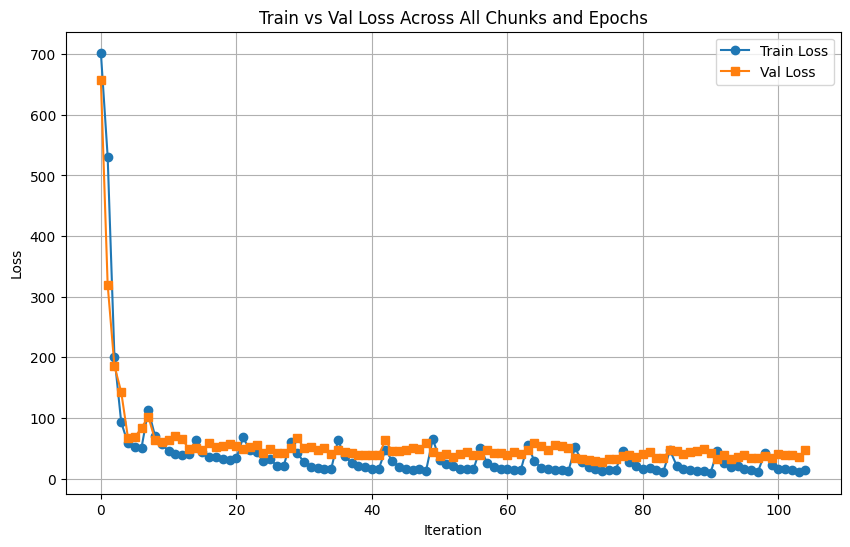

In [4]:
!pip install blitz-bayesian-pytorch
# ============================== 0. Runtime setup ==============================

import numpy as np, pickle, os, random, time, math, json
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import drive
import torch
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)  # don’t pre-grab all VRAM
tf.keras.mixed_precision.set_global_policy('mixed_float16')  # ½-size tensors
from torch.utils.data import Dataset , DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, mean_absolute_error
import seaborn as sns
import os

import pickle
import torch
import torch.nn as nn
import torch.optim as optim


class UTKFaceDataset(Dataset):
    def __init__(self, images, ages, genders, ethnicities):
        self.images = images
        self.ages = ages
        self.genders = genders
        self.ethnicities = ethnicities

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # Get labels
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        gender = torch.tensor(self.genders[idx], dtype=torch.float32)
        ethnicity = torch.tensor(self.ethnicities[idx], dtype=torch.long)
        #
        return image, age, gender, ethnicity
# ------------------------------------------------------------------------------
# 1.  Mount Google Drive
# ------------------------------------------------------------------------------
drive.mount('/content/drive')

# ------------------------------------------------------------------------------
# 5.  Model definition (ResNet-152 w/ ReLU age head)
# ------------------------------------------------------------------------------
from tensorflow.keras.layers import (Input, Conv2D, LayerNormalization, ReLU,
                                     Dropout, Add, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense)
from tensorflow.keras.models import Model
import torch, torch.nn as nn
from torchvision.models import resnet152, ResNet152_Weights

import torch
import torch.nn as nn
from torchvision.models import resnet152, ResNet152_Weights
from blitz.modules import BayesianLinear

def compute_kl(model: torch.nn.Module) -> torch.Tensor:
    """
    Sum up the KL penalty from every BayesianLinear layer in the model.
    """
    kl = torch.tensor(0.0, device=next(model.parameters()).device)
    for module in model.modules():
        # BayesianLinear layers have a .kl_loss attribute
        if hasattr(module, "kl_loss"):
            kl = kl + module.kl_loss
    return kl

class AgeGenderNet(nn.Module):
    def __init__(self, dropout: float = 0.2, unfreeze_layers: list[str] = None):
        super().__init__()
        # Load pretrained ResNet-152 backbone
        self.backbone = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
        self.backbone.fc = nn.Identity()  # remove original classification head

        # Determine which backbone layers to unfreeze
        # Default: unfreeze layer3 and layer4 for deeper fine-tuning
        if unfreeze_layers is None:
            unfreeze_layers = ["layer3", "layer4"]

        # Freeze all backbone layers, then unfreeze selected ones
        for name, param in self.backbone.named_parameters():
            param.requires_grad = any(name.startswith(layer) for layer in unfreeze_layers)

        # Shared BatchNorm + Dropout on feature vector
        self.bn_shared = nn.BatchNorm1d(2048)
        self.drop_shared = nn.Dropout(dropout)

        # Age regression head with LeakyReLU activation
        self.age_head = nn.Sequential(
            nn.Linear(2048,256),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(256,128),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(128,1)
        )

        # Gender classification head with ReLU activation
        self.gender_head = nn.Sequential(
            BayesianLinear(2048,256),
            nn.ReLU(),
            nn.Dropout(dropout),
            BayesianLinear(256,128),
            nn.ReLU(),
            nn.Dropout(dropout),
            BayesianLinear(128,1)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Extract backbone features
        feat = self.backbone(x)                 # -> (N, 2048)
        feat = self.bn_shared(feat)
        feat = self.drop_shared(feat)

        # Compute age and gender outputs
        age_logits = self.age_head(feat)         # raw regression value
        gender_logits = self.gender_head(feat)   # raw classification score
        gender_prob = torch.sigmoid(gender_logits)

        return age_logits, gender_prob




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DROPOUT_RATE=0.2
model = AgeGenderNet(dropout=DROPOUT_RATE).to(device)

import torch.nn as nn
import torch.optim as optim
criterion_age = nn.MSELoss()
criterion_gender = nn.BCELoss()
criterion_ethnicity = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1.5e-4,weight_decay=1e-6)




chunk_dir = "/content/drive/MyDrive/Colab Notebooks/pkl_files"
chunk_files = sorted([
    os.path.join(chunk_dir, f) for f in os.listdir(chunk_dir) if f.endswith('.pkl')
])

losses = []
f1_scores = []
num_epochs=7
# --- 1. Training step ---
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, ages, genders, _ in dataloader:
        if isinstance(images, list):
            images = torch.stack(images)
        images = images.to(device)
        ages   = ages.to(device).unsqueeze(1)
        genders= genders.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        out_age, out_gender = model(images)

        loss_age    = criterion_age(out_age, ages)
        loss_gender = criterion_gender(out_gender, genders)
        loss = 0.5 * loss_age + 1.5 * loss_gender

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(dataloader)

# --- 2. Validation loss only ---
def evaluate_loss(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, ages, genders, _ in dataloader:
            if isinstance(images, list):
                images = torch.stack(images)
            images = images.to(device)
            ages   = ages.to(device).unsqueeze(1)
            genders= genders.to(device).unsqueeze(1).float()

            out_age, out_gender = model(images)
            loss_age    = criterion_age(out_age, ages)
            loss_gender = criterion_gender(out_gender, genders)
            loss = 0.5 * loss_age + 1.5 * loss_gender
            running_loss += loss.item()

    return running_loss / len(dataloader)

# --- 3. Continuous training across chunks ---
train_losses, val_losses = [], []

for i, chunk_path in enumerate(chunk_files[:-9]):
    # Load your chunk as before
    with open(chunk_path, 'rb') as f:
        data = pickle.load(f)
    images = data['images']
    ages   = data['ages']
    genders= data['genders']
    ethnics= data['ethnicities']

    # Build datasets and loaders
    train_df, val_df = train_test_split(list(zip(images, ages, genders, ethnics)),
                                         test_size=0.25, random_state=42)
    train_dataset = UTKFaceDataset(*zip(*train_df))
    val_dataset   = UTKFaceDataset(*zip(*val_df))
    train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader    = torch.utils.data.DataLoader(val_dataset,   batch_size=32, shuffle=False)

    # Epoch loop for this chunk
    for epoch in range(num_epochs):
        tr_loss = train_epoch(model, train_loader, optimizer, device)
        vl_loss = evaluate_loss(model, val_loader, device)

        train_losses.append(tr_loss)
        val_losses.append(vl_loss)

        print(f"Chunk {i} | Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {tr_loss:.4f} | Val Loss: {vl_loss:.4f}")

# --- 4. Plot continuous train vs val loss ---
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses,   label='Val Loss',   marker='s')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Train vs Val Loss Across All Chunks and Epochs')
plt.show()




In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Path to your image
image_path = "/content/drive/MyDrive/308909_v9_bb.jpg"

# Define the same transforms as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),


    transforms.ToTensor(), # Converts to [C,H,W] and scales to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

# Load image and apply transform
img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension → shape: [1, 3, 224, 224]



In [ ]:
model.eval()
with torch.no_grad():
    pred_age, pred_gender = model(input_tensor)

print("Raw age (as float):", pred_age.item())
print("Raw gender (as float):", pred_gender.item())

# Postprocess
pred_age = (pred_age.item() *116 )/255  # Un-normalize age
pred_gender = "Female" if pred_gender.item() > 0.5 else "Male"

print(f"Predicted Age: {pred_age:.1f}")
print(f"Predicted Gender: {pred_gender}")



Raw age (as float): 469.0896911621094
Raw gender (as float): 0.9986139535903931
Predicted Age: 213.4
Predicted Gender: Female


1002


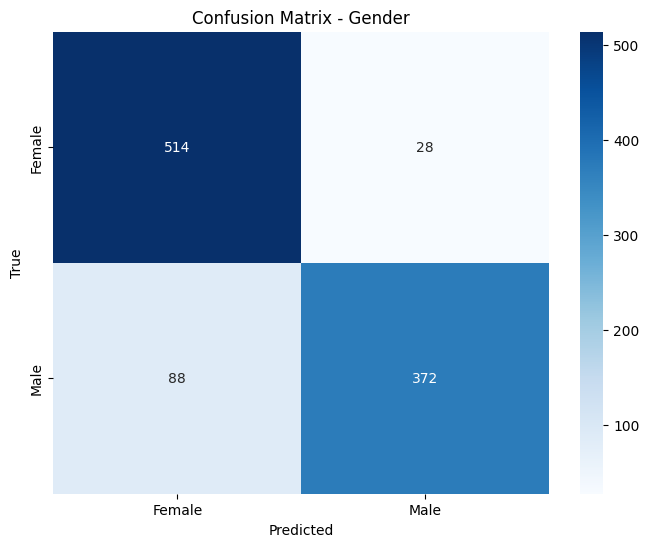

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90       542
         1.0       0.93      0.81      0.87       460

    accuracy                           0.88      1002
   macro avg       0.89      0.88      0.88      1002
weighted avg       0.89      0.88      0.88      1002



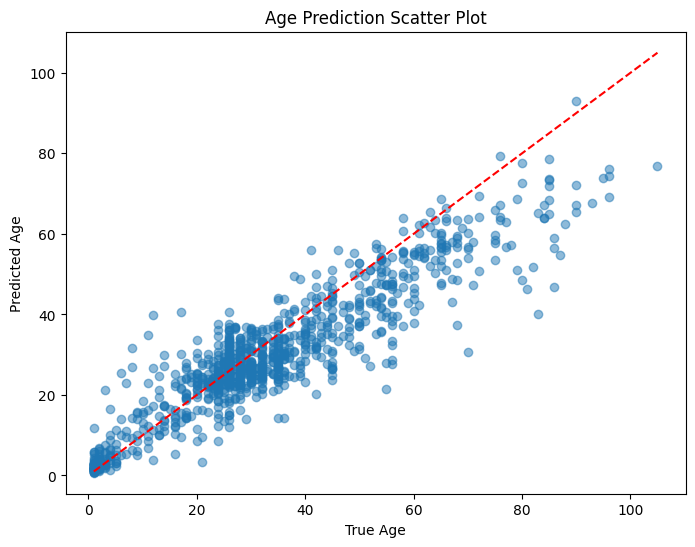

0.8050848419008265
6.311825155557511


In [10]:
#load chunk 17, and run it as a validation
chunk_path = '/content/drive/MyDrive/Colab Notebooks/pkl_files/chunk_18.pkl'
with open(chunk_path, 'rb') as f:
    data_dict = pickle.load(f)

print(len(data_dict['ages']))
df = []
for i in range(len(data_dict['ages'])):
  thing = [data_dict['images'][i], data_dict['ages'][i], data_dict['genders'][i], data_dict['ethnicities'][i]]

  df.append(thing)

val_ages = [row[1] for row in df]
val_genders = [row[2] for row in df]
val_ethnicities = [row[3] for row in df]

val_images = [row[0] for row in df]

val_dataset = UTKFaceDataset(val_images,val_ages,val_genders,val_ethnicities)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


##perform prediction
model.eval()
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)



#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_genders = []
pred_genders = []
true_ethnicities = []
pred_ethnicities = []

with torch.no_grad():
    for images, ages, genders,ethnicities in test_loader:

      images = images.to(device)
      ages = ages.to(device).unsqueeze(1)
      genders = genders.to(device).unsqueeze(1).float()
      out_age, out_gender = model(images)

      true_genders.extend(genders.cpu().numpy())
      pred_genders.extend((out_gender > 0.52).float().cpu().numpy())
      # true_ethnicities.extend(ethnicities.cpu().numpy())
      # pred_ethnicities.extend(out_ethnicity.argmax(dim=1).cpu().numpy())

# Confusion matrix for gender
cm_gender = confusion_matrix(true_genders, pred_genders)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Gender')
plt.show()

#classfication report
from sklearn.metrics import classification_report
print(classification_report(true_genders, pred_genders))

#confusion matrix for age
true_ages = []
pred_ages = []

with torch.no_grad():
    for images, ages, genders,ethnicities in test_loader:
        images = images.to(device)
        ages = ages.to(device).unsqueeze(1)
        genders = genders.to(device).unsqueeze(1).float()
        out_age, out_gender = model(images)
        true_ages.extend(ages.cpu().numpy())
        pred_ages.extend(out_age.cpu().numpy())

# Scatter plot for age prediction
plt.figure(figsize=(8, 6))
plt.scatter(true_ages, pred_ages, alpha=0.5)
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Age Prediction Scatter Plot')
plt.plot([min(true_ages), max(true_ages)], [min(true_ages), max(true_ages)], 'r--')
plt.show()

#calculate r^2
from sklearn.metrics import r2_score
r2 = r2_score(true_ages, pred_ages)
print(r2)

from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(true_ages,pred_ages)
print(mae)




In [ ]:
import torch, pathlib
!pip install onnx
import onnx
onnx_path = pathlib.Path("/content/drive/MyDrive/age_gender_half_bayes.onnx")

model.eval().cpu()                          # ONNX export needs CPU tensors
dummy = torch.randn(1, 3, 224, 224)         # NCHW, batch-size 1

torch.onnx.export(
    model, dummy, onnx_path,
    input_names  = ["image"],
    output_names = ["age", "gender"],
    dynamic_axes = {"image":  {0: "batch"},
                    "age":    {0: "batch"},
                    "gender": {0: "batch"}},
    opset_version=17,                       # 17 ↔ TF 2.16+
)
print("✅  ONNX written to", onnx_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 107.5 MB/s eta 0:00:00
✅  ONNX written to /content/drive/MyDrive/age_gender_new.onnx
